In [2]:
## importing Necessary libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Modules related to preprocessing (Imputation of missings, standardiszation, new features creation, converting categorical to numerical)
from sklearn.preprocessing import  PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, OrdinalEncoder


#Moudles related to feature selection
from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel, mutual_info_regression, SelectFpr, SelectFdr, SelectFwe

#Module related to calculation of metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

#Modules related key techniques of supervised learning 
import statsmodels.formula.api as sm
import statsmodels.tsa as tsa
import scipy.stats as stats


## Importing logger for logging information
from Info_logger import logging



## Importing the Regressors for model creation 
from sklearn.linear_model import  LinearRegression, Lasso, Ridge
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.tree import  DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import  SVR

In [3]:
logging.info("Importing all the datasets needed")

# Importing the Datasets
Y_var = pd.read_excel(
    'A:\Analytix\Machine learning\ML projects\Predict Cred Card Consumption\Predict Cred Card Consumption\Data\CreditConsumptionData.xlsx'
    )

cust_Behav = pd.read_excel(
    'A:\Analytix\Machine learning\ML projects\Predict Cred Card Consumption\Predict Cred Card Consumption\Data\CustomerBehaviorData.xlsx'
    )

cust_demo = pd.read_excel(
    'A:\Analytix\Machine learning\ML projects\Predict Cred Card Consumption\Predict Cred Card Consumption\Data\CustomerDemographics.xlsx'
    )

In [4]:
logging.info("creating a Profiling report for customer demographics & customer behavior")

# Creating a profiling report for Customer Demographics
report_cust_demo = pandas_profiling.ProfileReport(cust_demo)
#report_cust_demo


# Creating a profiling report for Customer Behaviour
report_cust_Behaviour = pandas_profiling.ProfileReport(cust_Behav)
#report_cust_Behaviour

In [5]:
logging.info("creating various functions for Nullvalue treatment, Outlier treatment, Model Evaluation function & Plotting functions")
             

## Function to treat missing values
def Null_treatment(x):
    for col in x.columns:
        if x[col].dtype == 'object':
         x[col].fillna(x[col].mode()[0],inplace=True)
        else:
           x[col].fillna(x[col].median(),inplace=True)
    return(x)       


## Function for Outlier treatment
def treat_outliers(df, lower_quantile=0.01, upper_quantile=0.99):
   

    treated_df = pd.DataFrame()
    
    for column in df.columns:
        lower_threshold = df[column].quantile(lower_quantile)
        upper_threshold = df[column].quantile(upper_quantile)
        
        treated_column = df[column].clip(lower_threshold, upper_threshold)
        treated_df[column] = treated_column
    
    return treated_df


## Function to create a QQ plot for every x variable to check the distribution
def dist_plot(dataset):
        
      # Iterate over each column in the dataset  
        for col in dataset.columns:
                
            plt.figure(figsize=(10,6))
        
        # Create a QQ plot for the current variable
            plt.subplot(1,2,1)
            dataset[col].hist()

            plt.subplot(1,2,2)
            stats.probplot(dataset[col],dist='norm',plot=plt)

        
            plt.title(f'Distribution of {col}')
            plt.show()


## Function to test the accuracy of the model by calculating MAE, MSE, MAPE, RSME, RMSPE
def evaluate_model(true_values, predicted_values):
    # Convert true and predicted values from log to exponential
    true_values_exp = np.exp(true_values)
    predicted_values_exp = np.exp(predicted_values)
    
    # Calculate MAE, MSE, and RMSE
    mae = mean_absolute_error(true_values_exp, predicted_values_exp)
    mse = mean_squared_error(true_values_exp, predicted_values_exp)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_values_exp, predicted_values_exp)
    
    # Calculate RMSPE
    rmspe = np.sqrt(np.mean(np.square((true_values_exp - predicted_values_exp) / true_values_exp)))

    print("MAE for model is ", mae)
    print("MSE for model is ", mse)
    print("Mape for model is ", mape)
    print("RMSE for model is ", rmse)
    print("RMSPE for model is ", rmspe)



## Function to create a histplot to check the distribution of errors
def plot_residuals(y_train_pred, y_test_pred):
  
    
    # Calculate residuals for training and test data
    residuals_train = y_train_N - y_train_pred
    residuals_test = y_test_N - y_test_pred

    # Plot histograms
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Train Residuals")
    sns.histplot(residuals_train, bins=20, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.title("Test Residuals")
    sns.histplot(residuals_test, bins=20, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()



## Function to create a scatter plot to check linear relationship between actual & predicted values
def plot_predicted_vs_actual(y_train_pred, y_test_pred):
   

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  
    # Scatter plot for training data
    ax[0].scatter(y_train_N, y_train_pred, color='blue', alpha=0.5)
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predicted Values')
    ax[0].set_title('Scatter plot of Predicted vs. Actual (Train Data)')
    ax[0].grid(True)
    

    # Scatter plot for test data
    ax[1].scatter(y_test_N, y_test_pred, color='red', alpha=0.5)
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Predicted Values')
    ax[1].set_title('Scatter plot of Predicted vs. Actual (Test Data)')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [6]:
logging.info("Initializing Data cleaning, Null value treatment, outlier treatment, encoding & standarding the data by log method")

In [7]:
# Merging the cust_demo & cust_behav
cust_demo_behav = pd.merge(left=cust_demo,right=cust_Behav,on="ID",how='right')

In [ ]:
#checking the null values
pd.DataFrame(cust_demo_behav.isna().sum())

In [ ]:
# Filling up the Null values
Null_treatment(cust_demo_behav)

In [10]:
# Aggregating the The coulumns which ar similar in Nature

# Average spend by Credit card spent
cust_demo_behav['CC_spent'] = (cust_demo_behav.cc_cons_apr + cust_demo_behav.cc_cons_may + cust_demo_behav.cc_cons_jun)/3

# Average spend by Debit card spent
cust_demo_behav['DC_spent'] = (cust_demo_behav.dc_cons_apr + cust_demo_behav.dc_cons_may + cust_demo_behav.dc_cons_jun)/3

# Average of No. of credit card transaction
cust_demo_behav['Num_CC_tran'] = round((cust_demo_behav.cc_count_apr + cust_demo_behav.cc_count_may + cust_demo_behav.cc_count_jun)/3)

# Average of No. of Debit card transaction
cust_demo_behav['Num_DC_tran']  = round((cust_demo_behav.dc_count_apr + cust_demo_behav.dc_count_may + cust_demo_behav.dc_count_jun)/3)

# Average of Investment by Customer
cust_demo_behav['Avg_Invsetment'] = round(
    (cust_demo_behav.investment_1 + cust_demo_behav.investment_2 + cust_demo_behav.investment_3 + cust_demo_behav.investment_4)/4)

# Total number of Active loans
cust_demo_behav['Active_loans'] = (cust_demo_behav.personal_loan_active + cust_demo_behav.vehicle_loan_active)

# Total number of Closed loans
cust_demo_behav['Closed_loans'] = (cust_demo_behav.personal_loan_closed + cust_demo_behav.vehicle_loan_closed)

# Average of Total Amount debited
cust_demo_behav['Avg_Amt_Debited'] = round(
    (cust_demo_behav.debit_amount_apr + cust_demo_behav.debit_amount_may + cust_demo_behav.debit_amount_jun)/3)

# Average of  Total Amount credited
cust_demo_behav['Avg_Amt_Credited'] = round(
    (cust_demo_behav.credit_amount_apr + cust_demo_behav.credit_amount_may + cust_demo_behav.credit_amount_jun)/3)

# Average of Maximum Amount credited
cust_demo_behav['Avg_Max_Amt_credited'] = round(
    (cust_demo_behav.max_credit_amount_apr + cust_demo_behav.max_credit_amount_may + cust_demo_behav.max_credit_amount_jun)/3)

# Average of Total No. of times Amount Debited
cust_demo_behav['Avg_No_Amt_Debited']  = round(
    (cust_demo_behav.debit_count_apr + cust_demo_behav.debit_count_may + cust_demo_behav.debit_count_jun)/3)

# Average of Total No. of times Amount Credited
cust_demo_behav['Avg_No_Amt_Credited'] = round(
    (cust_demo_behav.credit_count_apr + cust_demo_behav.credit_count_may + cust_demo_behav.credit_count_jun)/3)


In [11]:
# Removing the columns which are not needed  
col_list = [
    'credit_count_jun','credit_count_may','credit_count_apr','debit_count_jun','debit_count_may','debit_count_apr','max_credit_amount_jun',
    'max_credit_amount_may','max_credit_amount_apr','credit_amount_jun','credit_amount_may','credit_amount_apr','debit_amount_jun',
    'debit_amount_may','debit_amount_apr','vehicle_loan_closed','personal_loan_closed','personal_loan_active','vehicle_loan_active',
    'investment_1','investment_2','investment_3','investment_4','dc_count_apr','dc_count_may','dc_count_jun','cc_count_apr','cc_count_may',
    'cc_count_jun','dc_cons_jun','dc_cons_may','dc_cons_apr','cc_cons_jun','cc_cons_may','cc_cons_apr'
    ]

cust_demo_behav = cust_demo_behav.drop(columns=col_list)

In [12]:
## Merging datasets under sample
sample = pd.merge(left=cust_demo_behav,right=Y_var,on="ID",how='inner')

## Dropping the "loan_enq" column as it only have one unique value which is Y
sample.drop(columns='loan_enq',inplace=True)

In [13]:
## Using Label encoder to covert "account type" & "gender" into numerical column
encoder = LabelEncoder()
sample[['account_type','gender']] = sample[['account_type','gender']].apply(encoder.fit_transform)


## Using Oridinal encoder to covert "Income" into numerical column
ord_encoder = OrdinalEncoder(categories=[['LOW','MEDIUM','HIGH']])
sample['Income'] = ord_encoder.fit_transform(sample[['Income']])

In [14]:
## Segragating the Data without "Y" variable to conduct final test as suggested
Final_test = sample.loc[sample['cc_cons'].isna()]
Final_test = Final_test.set_index('ID')
Final_test = Final_test.drop(columns='cc_cons')

In [17]:
## Getting the data For model training & selection 
cust_360 = sample.dropna(axis=0)

#cust_360.drop(columns=['region_code'],inplace=True)
cust_360 = cust_360.set_index('ID')
cust_360

,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,card_lim,...,Num_DC_tran,Avg_Invsetment,Active_loans,Closed_loans,Avg_Amt_Debited,Avg_Amt_Credited,Avg_Max_Amt_credited,Avg_No_Amt_Debited,Avg_No_Amt_Credited,cc_cons
ID,,,,,,,,,,,,,,,,,,,,,
17051,0,1,30,1.0,7.0,5,956.0,1,20.0,358000,...,32.0,110751.0,2,2.0,38480.0,39340.0,48814.0,76.0,13.0,13434.0
11491,0,1,37,0.0,10.2,8,966.0,1,5.0,114000,...,7.0,1605576.0,2,2.0,53808.0,31137.0,23696.0,31.0,13.0,449.0
7433,0,1,33,1.0,3.9,3,505.0,1,15.0,360000,...,36.0,52426.0,2,2.0,40385.0,30455.0,23907.0,24.0,40.0,11968.0
14606,0,1,63,0.0,25.8,6,631.0,0,15.0,155000,...,31.0,115004.0,2,2.0,89745.0,43618.0,96506.0,27.0,24.0,32029.0
8381,1,1,33,1.0,6.5,7,698.0,0,9.0,362000,...,31.0,6604.0,2,2.0,66654.0,329982.0,18874.0,25.0,13.0,16394.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,53,0.0,13.2,9,653.0,1,20.0,520000,...,43.0,56845.0,2,2.0,182954.0,32484.0,39132.0,32.0,6.0,4263.0
10376,0,1,44,1.0,2.4,9,535.0,1,2.0,472000,...,3.0,62972.0,2,2.0,35496.0,36269.0,117087.0,27.0,6.0,11019.0
2181,0,1,37,1.0,3.4,9,464.0,1,8.0,44000,...,10.0,117206.0,2,2.0,50942.0,130716.0,45017.0,27.0,16.0,404227.0


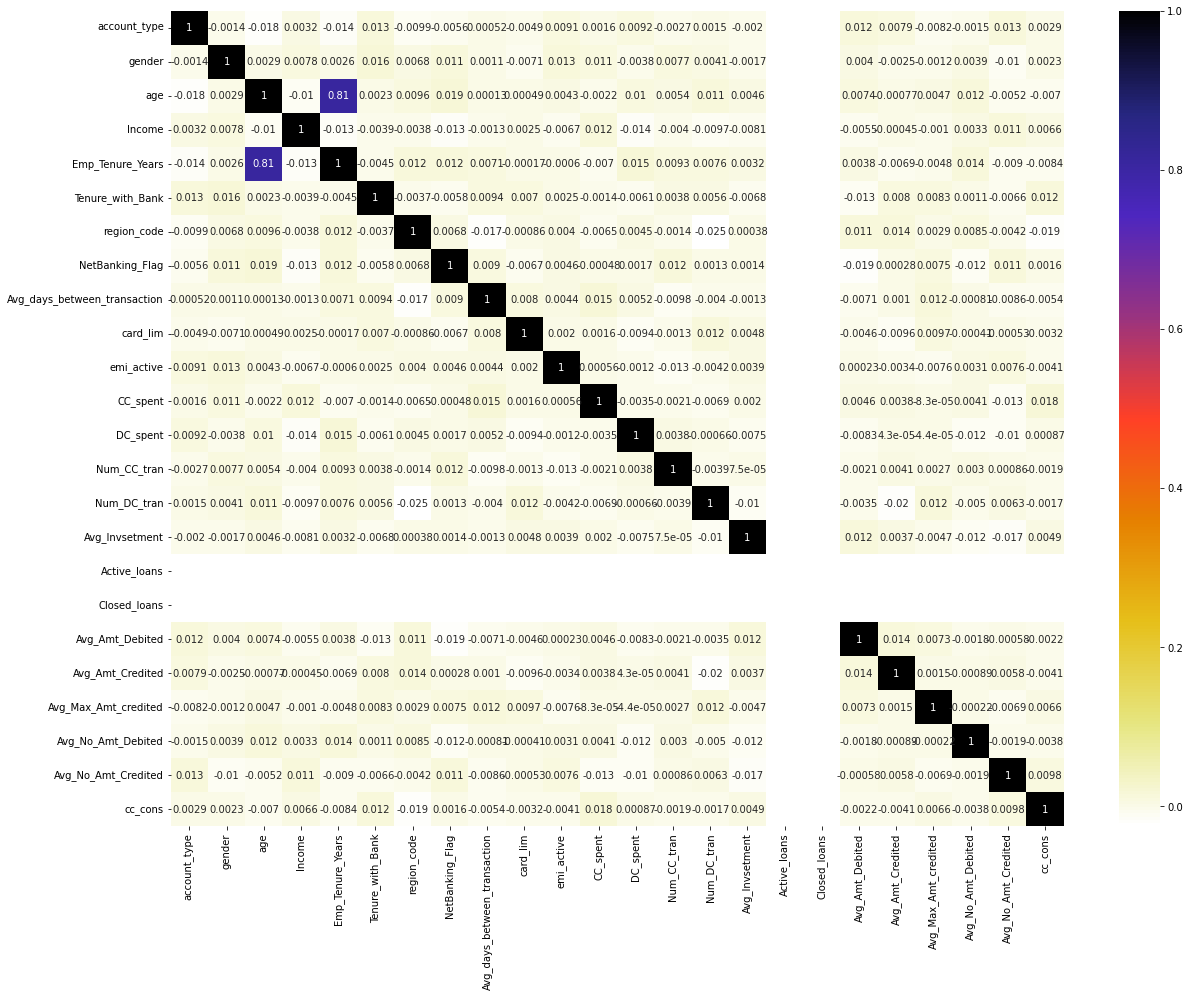

In [18]:
## Creating a correlation plot to check multicolinearity
plt.figure(figsize=(20,15))
sns.heatmap(data=cust_360.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [19]:
# Separating X and y variables
X = cust_360.iloc[:, :-1]  # Select all columns except Y variables
y = cust_360.iloc[:, -1]  # Select the last column as the target variable

In [20]:
## segragating the Numerical & Categorical columns
X_cat = X[['account_type','gender','Income','NetBanking_Flag','region_code']]
X_num = X.drop(columns=['account_type','gender','Income','NetBanking_Flag','region_code'])


## segragating the Numerical & Categorical columns for final_test_data
Final_test_X_cat = Final_test[['account_type','gender','Income','NetBanking_Flag','region_code']]
Final_test_X_num = Final_test.drop(columns=['account_type','gender','Income','NetBanking_Flag','region_code'])

In [21]:
## checking the insight of the Numerical columns
X_num.describe()

,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,card_lim,emi_active,CC_spent,DC_spent,Num_CC_tran,Num_DC_tran,Avg_Invsetment,Active_loans,Closed_loans,Avg_Amt_Debited,Avg_Amt_Credited,Avg_Max_Amt_credited,Avg_No_Amt_Debited,Avg_No_Amt_Credited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.0,15000.0,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000
mean,47.790600,15.184007,5.510000,11.049600,277005.147400,1.576060e+04,15474.485738,7657.366270,38.827067,20.476400,2.251845e+05,2.0,2.0,6.997967e+04,8.095671e+04,5.472132e+04,40.684200,14.388733
std,30.632766,20.312648,2.865783,5.492196,179429.540139,1.179152e+05,13788.216308,9123.414646,39.776586,12.998058,7.794590e+05,0.0,0.0,7.190188e+04,1.014634e+05,1.024400e+05,20.846057,11.401954
min,25.000000,0.500000,1.000000,2.000000,0.000000,0.000000e+00,514.956667,232.796667,1.000000,1.000000,-1.299000e+03,2.0,2.0,2.815000e+03,3.920000e+02,1.362000e+03,1.000000,0.000000
25%,33.000000,5.100000,3.000000,6.000000,124000.000000,1.549770e+03,7341.335833,3232.310000,18.000000,10.000000,3.497500e+04,2.0,2.0,3.622575e+04,4.044050e+04,2.739650e+04,25.000000,5.000000
50%,40.000000,9.900000,6.000000,11.000000,272000.000000,3.954430e+03,11825.205000,5333.910000,30.000000,19.000000,6.856050e+04,2.0,2.0,5.344800e+04,6.068350e+04,3.876500e+04,38.000000,12.000000
75%,53.000000,18.000000,8.000000,16.000000,400000.000000,9.376390e+03,19059.925000,8962.494167,45.000000,29.000000,1.477112e+05,2.0,2.0,8.108825e+04,9.264400e+04,5.829875e+04,53.000000,19.000000
max,223.000000,203.000000,10.000000,20.000000,1000000.000000,7.447125e+06,387231.370000,310904.150000,407.000000,73.000000,1.664289e+07,2.0,2.0,2.263113e+06,3.631766e+06,4.029165e+06,141.000000,77.000000


In [ ]:
## Checking for outliers by Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(data=X_num,orient="h")
plt.show()

In [23]:
## Treating the Outliers for X_num
X_num = treat_outliers(X_num)

## Treating the Outliers for Final_test_X_num
Final_test_X_num = treat_outliers(Final_test_X_num)

#### As per the findings maximum age is reflecting 200+ & Employement Tenure years showing a max of 100+ years.

##### Both the scenarios are not posible naturally, So replacing the values with median.

##### Taking threshold value for age is "80" & threshold value for Employement tenure is "30", Replacing both with the Median.

In [24]:
## Replacing the inappropriate Age & Tenure with median for X_num
X_num.loc[X_num['age'] > 80,'age'] = X_num['age'].median()
X_num.loc[X_num['Emp_Tenure_Years'] > 30,'Emp_Tenure_Years'] = X_num['Emp_Tenure_Years'].median()


## Replacing the inappropriate Age & Tenure with median for Final_test_X_num
Final_test_X_num.loc[Final_test_X_num['age'] > 80,'age'] = Final_test_X_num['age'].median()
Final_test_X_num.loc[Final_test_X_num['Emp_Tenure_Years'] > 30,'Emp_Tenure_Years'] = Final_test_X_num['Emp_Tenure_Years'].median()

In [ ]:
## Creating QQ plot for each X variable to check the distribution
dist_plot(X_num)

## Creating dist. plot for Y variable to check the distribution
sns.distplot(y)
plt.title("Target variable before applying log")
plt.show()

In [26]:
## Applying log on X & Y variable to get the distribution as close to Normal
X_Log = X_num.applymap(lambda x: np.log(x + 1))
Y_Log = np.log(y+1)

## Applying log on Final_test_X_num to get the distribution as close to Normal
Final_test_X_num = Final_test_X_num.applymap(lambda x: np.log(x + 1))

In [ ]:
## Creating QQ plot for each X variable to check the distribution after applying Log
dist_plot(X_Log)

## Creating dist. plot for Y variable to check the distribution after applying Log
sns.distplot(Y_Log)
plt.title("Target variable after applying log")
plt.show()

In [28]:
## Joining the categorical & Numerical columns under "X_New"
X_New = pd.concat([X_Log,X_cat], axis=1)

## Joining the categorical & Numerical columns under "Final_test_Data"
Final_test_Data = pd.concat([Final_test_X_num,Final_test_X_cat], axis=1)

In [29]:
logging.info("Data cleaning, Encoding & Standardization comleted")

### Performing Feature selection

In [30]:
logging.info("Initializing Feature selection by using Recursive Feature Elimination & Select K-Best method")

In [31]:
## Finding Top 10 important features using RFE
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=10)

rfe = rfe.fit(X_New, y)

imp_vars_RFE = list(X.columns[rfe.support_])

In [32]:
## Finding Top 10 important features using SKB
SKB = SelectKBest(f_regression, k=10).fit(X_New, y)

SKB.get_support()

imp_vars_SKB = list(X.columns[SKB.get_support()])

In [33]:
#Creating a combined list of the top features by merging the result of RFE & SKB
RFE_features = set(imp_vars_RFE)

SKB_features = set(imp_vars_SKB)

Final_features = list(RFE_features.union(SKB_features))

Final_X_Var = X_New[Final_features]


#Creating a combined list of the top features by merging the result of RFE & SKB for Final_test_Data
Final_test_Data = Final_test_Data[Final_features]

In [ ]:
## Creating a heatmap to check the correlation between final X variables
plt.figure(figsize=(15,12))
sns.heatmap(data=Final_X_Var.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [35]:
## Train test split
X_train_N,X_test_N,y_train_N,y_test_N=train_test_split(Final_X_Var,Y_Log,test_size=0.20,random_state=42)

In [36]:
logging.info("Feature selection & Train Test split of the data completed")

# Model Building & Selection

In [37]:
logging.info("Intializing Model building & Best Model selection")

#### Ridge Regresssor Model

Ridge Reg train model scores
MAE for model is  48758.87564266544
MSE for model is  11117651812.403866
Mape for model is  5.829758101190707
RMSE for model is  105440.27604480114
RMSPE for model is  153.7288879641985
***********************************
Ridge Reg test model scores
MAE for model is  48143.87698780383
MSE for model is  11058398298.659477
Mape for model is  4.537415436373322
RMSE for model is  105158.91925395334
RMSPE for model is  34.61059523136981


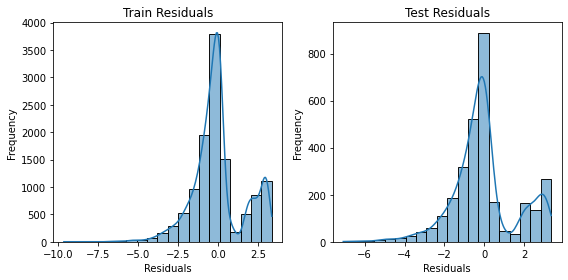

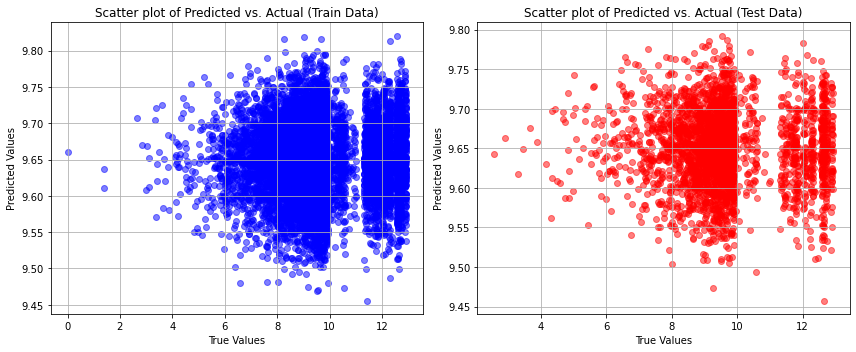

In [38]:
## Creating Ridge regressor model
Ridge_Reg = Ridge()

## Fitting the model on train data
Ridge_Reg.fit(X_train_N,y_train_N)

## Predicting for train & test data
Ridge_train_pred = Ridge_Reg.predict(X_train_N)
Ridge_test_pred = Ridge_Reg.predict(X_test_N)

## Getting the scores for train & test model
print("Ridge Reg train model scores")
evaluate_model(y_train_N,Ridge_train_pred)

print("***********************************")

print("Ridge Reg test model scores")
evaluate_model(y_test_N,Ridge_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Ridge_train_pred,Ridge_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Ridge_train_pred,Ridge_test_pred)

#### Lasso Regresssor Model

Lasso Reg train model scores
MAE for model is  48747.551553212164
MSE for model is  11122431974.565382
Mape for model is  5.8423307061978
RMSE for model is  105462.94123797886
RMSPE for model is  153.125354336175
***********************************
Lasso Reg test model scores
MAE for model is  48117.9473509673
MSE for model is  11057250508.207321
Mape for model is  4.518824845468347
RMSE for model is  105153.46170339482
RMSPE for model is  34.54891336055884


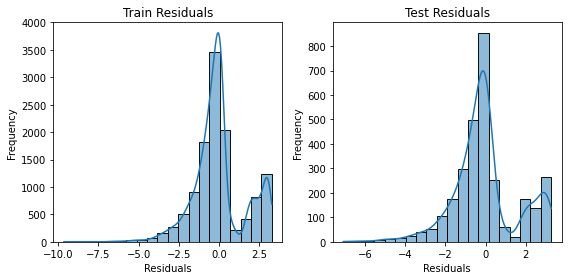

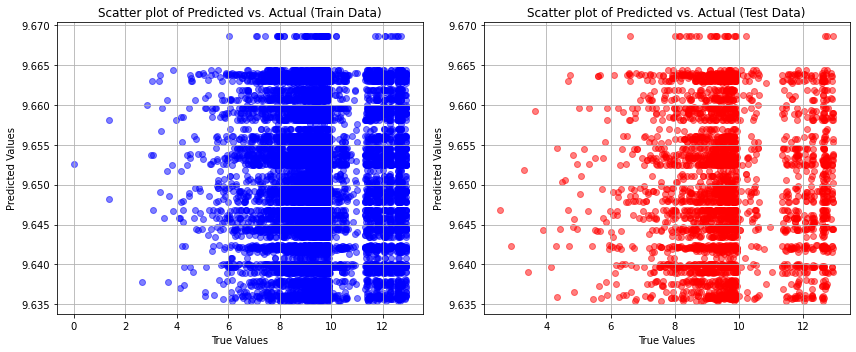

In [39]:
## Creating Lasso regressor model
Lasso_Reg = Lasso()

## Fitting the model on train data
Lasso_Reg.fit(X_train_N,y_train_N)

## Predicting for train & test data
Lasso_train_pred = Lasso_Reg.predict(X_train_N)
Lasso_test_pred = Lasso_Reg.predict(X_test_N)

## Getting the scores for train & test model
print("Lasso Reg train model scores")
evaluate_model(y_train_N,Lasso_train_pred)

print("***********************************")

print("Lasso Reg test model scores")
evaluate_model(y_test_N,Lasso_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Lasso_train_pred,Lasso_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Lasso_train_pred,Lasso_test_pred)

#### Linear Regresssor Model

Linear Reg train model scores
MAE for model is  48758.886324381965
MSE for model is  11117650382.688896
Mape for model is  5.829762427636252
RMSE for model is  105440.26926506255
RMSPE for model is  153.7298194367187
***********************************
Linear Reg test model scores
MAE for model is  48143.89236970505
MSE for model is  11058398661.368998
Mape for model is  4.537425989637029
RMSE for model is  105158.92097853133
RMSPE for model is  34.610666016197975


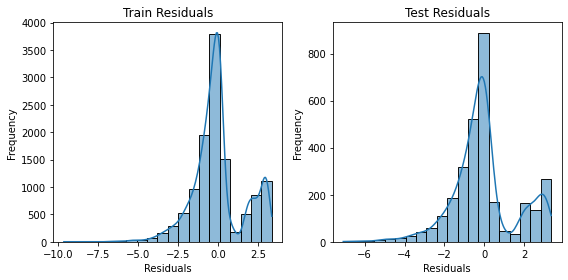

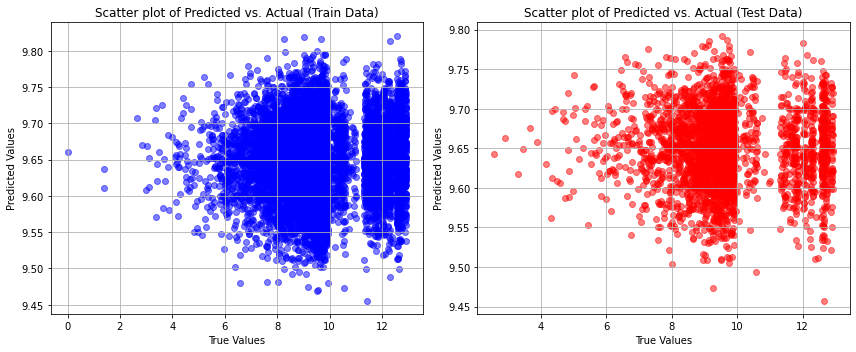

In [40]:
## Creating Linear regressor model
Lin_Reg = LinearRegression()

## Fitting the model on train data
Lin_Reg.fit(X_train_N,y_train_N)

## Predicting for train & test data
Lin_Reg_train_pred = Lin_Reg.predict(X_train_N)
Lin_Reg_test_pred = Lin_Reg.predict(X_test_N)

## Getting the scores for train & test model
print("Linear Reg train model scores")
evaluate_model(y_train_N,Lin_Reg_train_pred)

print("***********************************")

print("Linear Reg test model scores")
evaluate_model(y_test_N,Lin_Reg_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Lin_Reg_train_pred,Lin_Reg_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Lin_Reg_train_pred,Lin_Reg_test_pred)

### Decision Tree Model

### Tuning parameters for Decision tree Model
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]}

DT = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5,scoring='neg_mean_squared_error')

DT.fit(X_train_N,y_train_N)

DT.best_params_

Decision Tree train model scores
MAE for model is  48727.59635634685
MSE for model is  11085904094.95422
Mape for model is  5.634570737819091
RMSE for model is  105289.62007222848
RMSPE for model is  136.21063923522058
***********************************
Decision Tree model scores
MAE for model is  48238.42606358389
MSE for model is  11044895070.612625
Mape for model is  4.589354135558411
RMSE for model is  105094.69573014912
RMSPE for model is  35.414984640439044


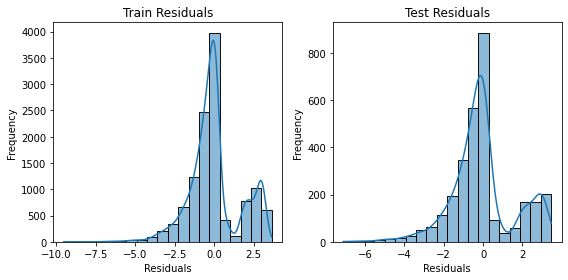

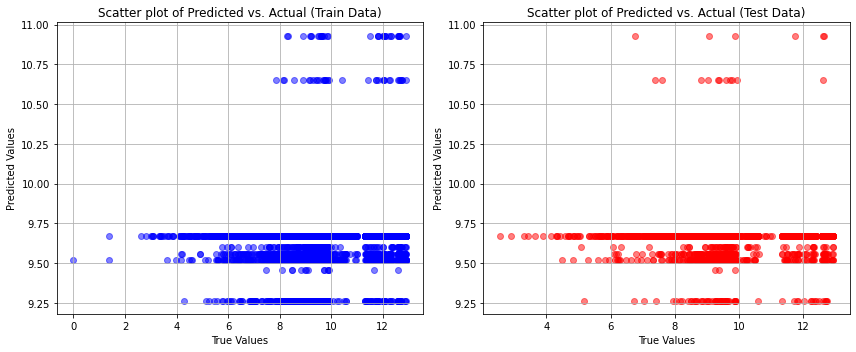

In [41]:
## Creating a Decision tree model using best parameters
DT_Reg_model = DecisionTreeRegressor(max_depth=3,min_samples_leaf=1,min_samples_split=2)

## Fitting the model on train data
DT_Reg_model.fit(X_train_N,y_train_N)

## Predicting for train & test data
DT_train_pred = DT_Reg_model.predict(X_train_N)
DT_test_pred = DT_Reg_model.predict(X_test_N)

## Getting the scores for train & test model
print("Decision Tree train model scores")
evaluate_model(y_train_N,DT_train_pred)

print("***********************************")

print("Decision Tree model scores")
evaluate_model(y_test_N,DT_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(DT_train_pred,DT_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(DT_train_pred,DT_test_pred)

#### Random Forest Model

### Tuning parameters for Random Forest Model
pargrid_ada = { 
            "n_estimators"      : [50, 100, 200],
            "min_samples_split" : [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [None, 5, 10]}

RF = GridSearchCV(estimator=RandomForestRegressor(), 

param_grid=pargrid_ada,                         

cv=5,n_jobs=-1,scoring='neg_mean_squared_error')                        

RF.fit(X_train_N,y_train_N)

RF.best_params_

Random Forest train model scores
MAE for model is  47558.83503783523
MSE for model is  10800883409.819183
Mape for model is  3.3415231163457495
RMSE for model is  103927.29867469463
RMSPE for model is  31.866394130829505
***********************************
Random Forest test model scores
MAE for model is  48228.69277881488
MSE for model is  11063042015.807787
Mape for model is  4.573859592253258
RMSE for model is  105180.99645757207
RMSPE for model is  35.46506003046647


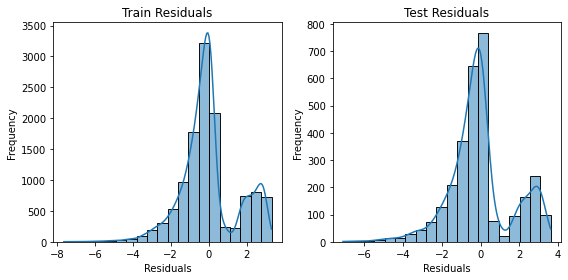

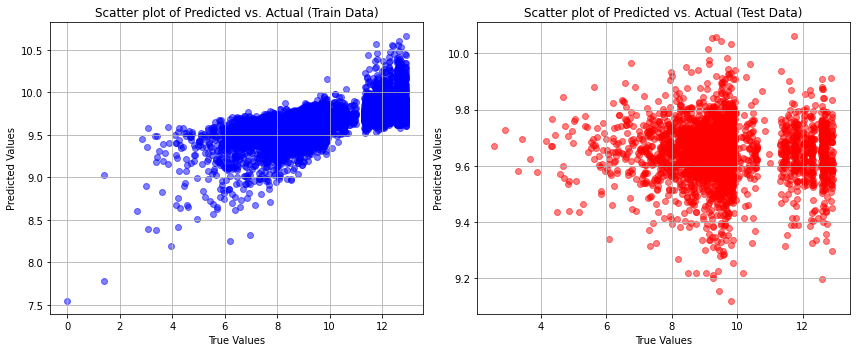

In [42]:
## Creating a Random forest Model using best parameters
RF_Reg_model = RandomForestRegressor(max_depth=9,min_samples_leaf=2,min_samples_split=5,n_estimators=200)

## Fitting the model on train data
RF_Reg_model.fit(X_train_N,y_train_N)

## Predicting for train & test data
RF_train_pred = RF_Reg_model.predict(X_train_N)
RF_test_pred = RF_Reg_model.predict(X_test_N)

## Getting the scores for train & test model
print("Random Forest train model scores")
evaluate_model(y_train_N,RF_train_pred)

print("***********************************")

print("Random Forest test model scores")
evaluate_model(y_test_N,RF_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(RF_train_pred,RF_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(RF_train_pred,RF_test_pred)

#### XG Boost Model

### Tuning Parameters For XG Boost Model 
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]}

XGB = GridSearchCV(estimator=XGBRegressor(), 

param_grid=param_grid, 

cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

XGB = XGB.fit(X_train_N,y_train_N)

XGB.best_params_

XG Boost train model scores
MAE for model is  48485.86220947266
MSE for model is  11125103254.535614
Mape for model is  5.06838731877165
RMSE for model is  105475.60502095077
RMSPE for model is  118.6642892134504
***********************************
XG Boost test model scores
MAE for model is  48101.864973958334
MSE for model is  11112585297.048777
Mape for model is  4.345450032677647
RMSE for model is  105416.24778490637
RMSPE for model is  33.190533229320536


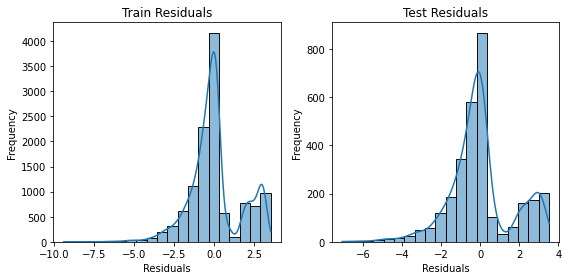

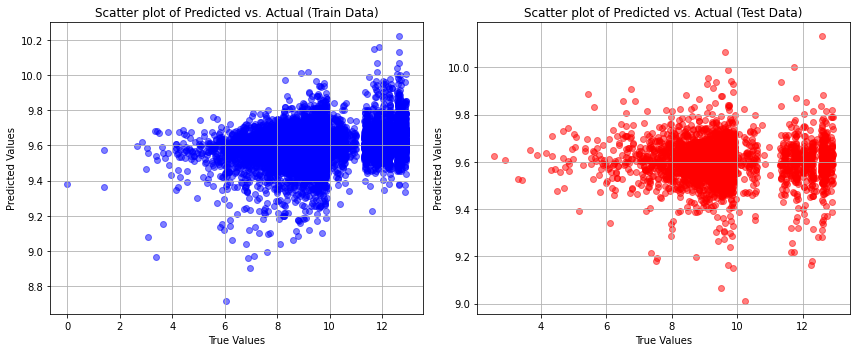

In [43]:
## Creating a XG Boost model using best parameters
XGB_reg_model = XGBRegressor(colsample_bytree=0.8,learning_rate= 0.1,n_estimators= 50,subsample= 1.0,max_depth=3)

## Fitting the model on train data
XGB_reg_model.fit(X_train_N,y_train_N)

## Predicting for train & test data
XGB_train_pred = XGB_reg_model.predict(X_train_N)
XGB_test_pred = XGB_reg_model.predict(X_test_N)

## Getting the scores for train & test model
print("XG Boost train model scores")
evaluate_model(y_train_N,XGB_train_pred)

print("***********************************")

print("XG Boost test model scores")
evaluate_model(y_test_N,XGB_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(XGB_train_pred,XGB_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(XGB_train_pred,XGB_test_pred)

#### SVR Model

#### Tuning Parameters for SVR Model  
param_grid = {
    "C": [0.1, 1, 10],
    "epsilon": [0.01, 0.1, 1]}
Svr_model = GridSearchCV(estimator= SVR(), param_grid=param_grid,cv=5,n_jobs=-1)

data_svr = Svr_model.fit(X_train_N,y_train_N)

data_svr.best_params_

SVR train model scores
MAE for model is  48756.12951186349
MSE for model is  11120232959.546114
Mape for model is  5.8729518685454245
RMSE for model is  105452.51518833543
RMSPE for model is  154.50695996838112
***********************************
SVR test model scores
MAE for model is  48123.9006261874
MSE for model is  11057890469.594421
Mape for model is  4.4947561016437545
RMSE for model is  105156.50464709457
RMSPE for model is  34.1024801210799


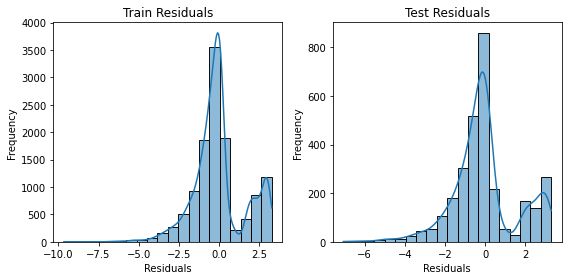

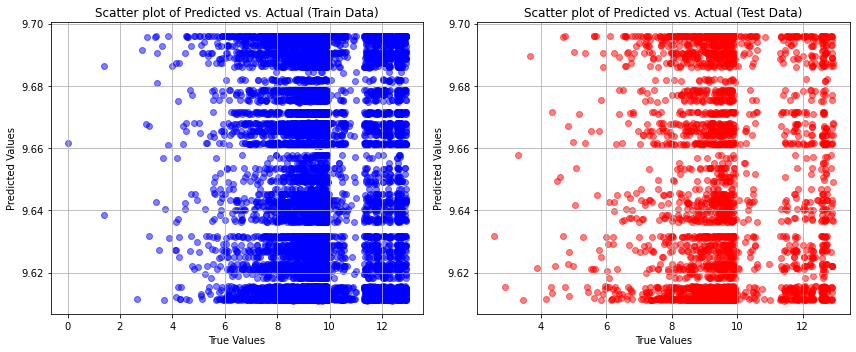

In [44]:
## Creating SVR Model using best parameters
SVR_Reg_model = SVR(C=0.1,epsilon=1,kernel='rbf')

## Fitting the model on train data
SVR_Reg_model.fit(X_train_N,y_train_N)

## Predicting for train & test data
SVR_train_pred = SVR_Reg_model.predict(X_train_N)
SVR_test_pred = SVR_Reg_model.predict(X_test_N)

## Getting the scores for train & test model
print("SVR train model scores")
evaluate_model(y_train_N,SVR_train_pred)

print("***********************************")

print("SVR test model scores")
evaluate_model(y_test_N,SVR_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(SVR_train_pred,SVR_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(SVR_train_pred,SVR_test_pred)

#### KNN Model

### Tuning parameters for KNN Model

param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]}
model = GridSearchCV(KNeighborsRegressor(), n_jobs=-1 ,param_grid = param_grid, cv=5, scoring = 'neg_mean_squared_error')

model = model.fit(X_train_N, y_train_N)

model.best_params_

KNN train model scores
MAE for model is  48868.40239245852
MSE for model is  10532246853.85356
Mape for model is  3.8615919817613054
RMSE for model is  102626.73557048163
RMSPE for model is  61.61580807843571
***********************************
KNN test model scores
MAE for model is  50282.506197158335
MSE for model is  10921846943.342241
Mape for model is  5.328048193197808
RMSE for model is  104507.64059791151
RMSPE for model is  47.26487847373576


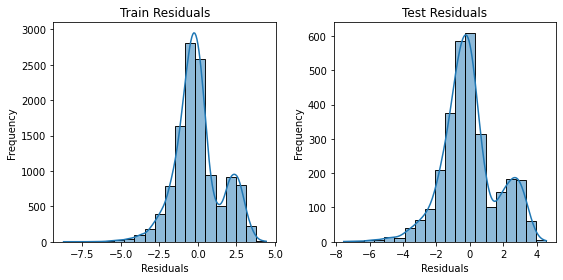

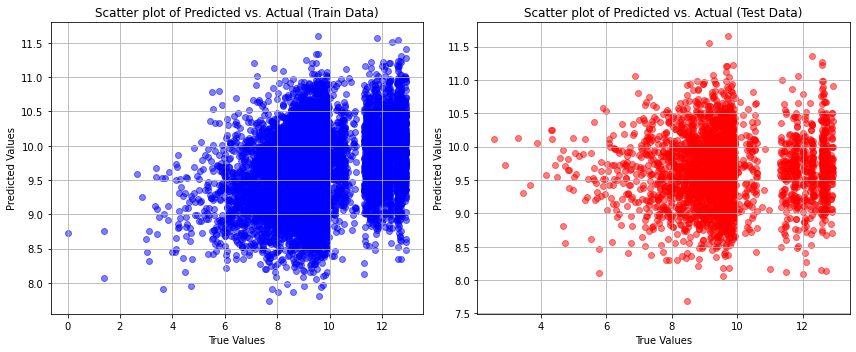

In [45]:
## Creating a KNN Model with best parameters
KNN_reg_model = KNeighborsRegressor(n_neighbors=10,p=3,weights='uniform')

## Fitting the model on train data
KNN_reg_model.fit(X_train_N, y_train_N)

## Predicting for train & test data
KNN_train_pred = KNN_reg_model.predict(X_train_N)
KNN_test_pred = KNN_reg_model.predict(X_test_N)

## Getting the scores for train & test model
print("KNN train model scores")
evaluate_model(y_train_N,KNN_train_pred)

print("***********************************")

print("KNN test model scores")
evaluate_model(y_test_N,KNN_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(KNN_train_pred,KNN_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(KNN_train_pred,KNN_test_pred)

#### Ensemble Model

### Tuning Parameters for Ensemble Model

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]}

gscv_bagging = GridSearchCV(estimator=BaggingRegressor(), 
param_grid=param_grid, 
cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

Bagg_Model =gscv_bagging.fit(X_train_N, y_train_N)

Bagg_Model.best_params_

Ensemble Bagging train model scores
MAE for model is  36590.46112010911
MSE for model is  7206264019.13834
Mape for model is  0.7600444027308431
RMSE for model is  84889.71680444186
RMSPE for model is  2.1248506314435662
***********************************
Ensemble Bagging test model scores
MAE for model is  48578.1394766093
MSE for model is  11047402784.901775
Mape for model is  4.629340876849035
RMSE for model is  105106.62578972733
RMSPE for model is  33.41293995700586


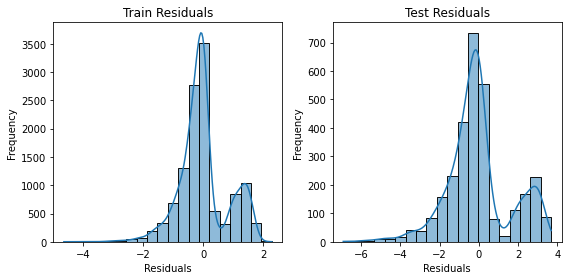

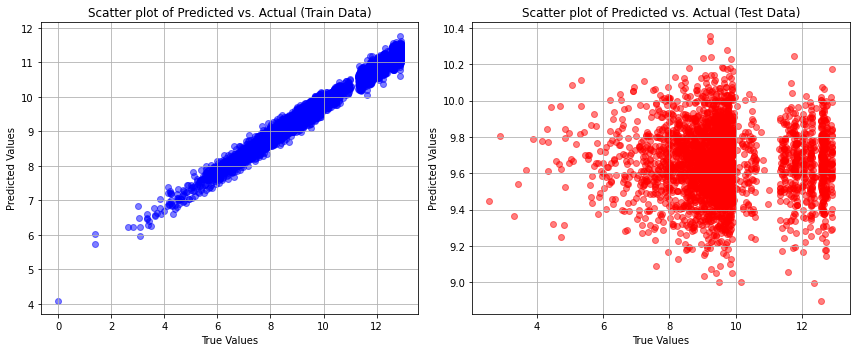

In [46]:
## Creating a Ensemble Bagging Model with best parameters
Bagg_Model = BaggingRegressor(max_features=0.7,max_samples=0.7,n_estimators=250)

## Fitting the model on train data
Bagg_Model.fit(X_train_N, y_train_N)

## Predicting for train & test data
Ensb_train_pred = Bagg_Model.predict(X_train_N)
Ensb_test_pred = Bagg_Model.predict(X_test_N)

## Getting the scores for train & test model
print("Ensemble Bagging train model scores")
evaluate_model(y_train_N,Ensb_train_pred)

print("***********************************")

print("Ensemble Bagging test model scores")
evaluate_model(y_test_N,Ensb_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Ensb_train_pred,Ensb_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Ensb_train_pred,Ensb_test_pred)

### Ada Boost

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]}

ada_boost = GridSearchCV(estimator=AdaBoostRegressor(), 
param_grid=param_grid, 
cv=5,
scoring='neg_mean_squared_error',
n_jobs=-1)

data_boost=ada_boost.fit(X_train_N, y_train_N)

data_boost.best_params_

Ada Boost train model scores
MAE for model is  48751.0442810545
MSE for model is  11102092255.69197
Mape for model is  5.702719935221294
RMSE for model is  105366.46646676527
RMSPE for model is  138.0964899123792
***********************************
Ada Boost test model scores
MAE for model is  48174.40501194649
MSE for model is  11044428639.760515
Mape for model is  4.602647336858602
RMSE for model is  105092.47660874929
RMSPE for model is  35.35719126191023


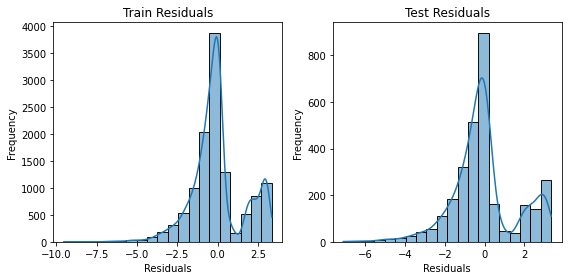

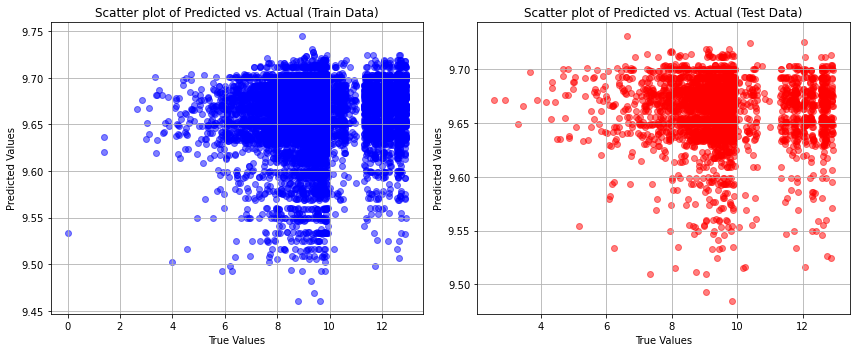

In [47]:
## Creating a Ada Boost Model with best parameters
Ada_Boost = AdaBoostRegressor(learning_rate = 0.001, n_estimators = 100)

## Fitting the model on train data
Ada_Boost.fit(X_train_N, y_train_N)

## Predicting for train & test data
Ada_train_pred = Ada_Boost.predict(X_train_N)
Ada_test_pred = Ada_Boost.predict(X_test_N)

## Getting the scores for train & test model
print("Ada Boost train model scores")
evaluate_model(y_train_N,Ada_train_pred)

print("***********************************")

print("Ada Boost test model scores")
evaluate_model(y_test_N,Ada_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Ada_train_pred,Ada_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Ada_train_pred,Ada_test_pred)

### Gradient boost

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5]}

Grad_boost_cv = GridSearchCV(estimator=GradientBoostingRegressor(), 
    param_grid=param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

Grad_boost = Grad_boost_cv.fit(X_train_N, y_train_N)

Grad_boost.best_params_

Gradient Boost train model scores
MAE for model is  48693.966938376834
MSE for model is  11104959228.067926
Mape for model is  5.615941275150806
RMSE for model is  105380.07035520487
RMSPE for model is  137.02629627476114
***********************************
Gradient Boost test model scores
MAE for model is  48156.722144979794
MSE for model is  11058065109.377234
Mape for model is  4.550294378971744
RMSE for model is  105157.33502413055
RMSPE for model is  34.944761315565685


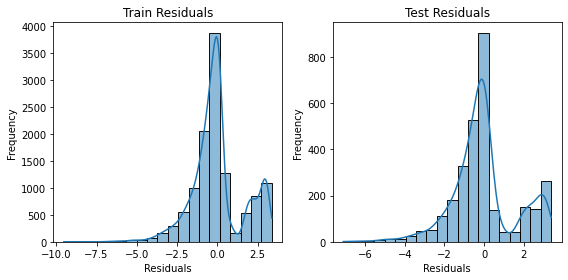

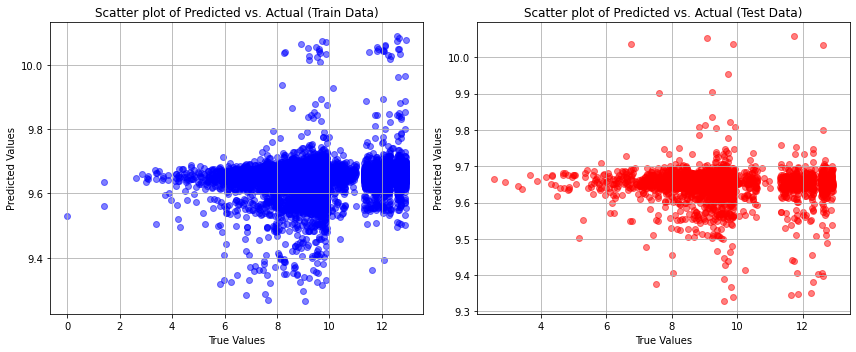

In [48]:
## Creating a Gradient Boost Model with best parameters
Grad_Boost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 100, max_depth = 3)

## Fitting the model on train data
Grad_Boost.fit(X_train_N, y_train_N)

## Predicting for train & test data
Grad_train_pred = Grad_Boost.predict(X_train_N)
Grad_test_pred = Grad_Boost.predict(X_test_N)

## Getting the scores for train & test model
print("Gradient Boost train model scores")
evaluate_model(y_train_N,Grad_train_pred)

print("***********************************")

print("Gradient Boost test model scores")
evaluate_model(y_test_N,Grad_test_pred)

## Creating residual plot for train & test data to check error distribution
plot_residuals(Grad_train_pred,Grad_test_pred)

## Creating scatter plot for train & test data to check relation between actual & predicted values
plot_predicted_vs_actual(Grad_train_pred,Grad_test_pred)

In [49]:
logging.info('Model Building & Selection comleted. Select Random Forest Model as it shows the best accuracy for both Train & Test Data among all the models without having the issue of overfitting or underfitting')

 #### Selecting Random Forest Model as it shows the best accuracy for both Train & Test Data among all the models without having the issue of overfitting or underfitting'

In [50]:
logging.info('Saving Random Forest Model into a pickle file')

import pickle

# saving best model into a picke file
with open('Random_Forest_Model.pkl', 'wb') as f:
    pickle.dump(RF_Reg_model, f)

logging.info('pickle file saved')

#### Predicting the Credit card spent for Final_test_data using random forest model

In [51]:
logging.info('Predicting spent for Final data of 5000 records as requested')

## Predicting spent for final test data 
Final_Prediction = pd.DataFrame(np.exp(RF_Reg_model.predict(Final_test_Data)))

## Saving the prediction into excel file 
Final_Prediction.to_excel('predicted_values.xlsx', index=False)

logging.info('Final Prediction saved as excel file under the name predicted_values.xlsx')